In [1]:
# Libraries
import pandas as pd, numpy as np, seaborn as sn, matplotlib.pyplot as plt, ipywidgets as widgets
from sklearn.model_selection import train_test_split
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn import metrics, preprocessing

## Fitur Utama Prabu

In [2]:
import joblib
import pandas as pd
import numpy as np
from ipywidgets import IntSlider, FloatSlider, Label, VBox, HBox, Layout
import ipywidgets as widgets
import matplotlib.pyplot as plt
from PrabuModule.dummy_data_prabu import get_dummy_data # Impor fungsi dari file data dummy

# Load model dari file joblib
best_model = joblib.load("PrabuModule/PrabuModel.joblib")

# ---- Integrasi Data Dummy ----
# Tentukan tahun dasar untuk fitur (misal 2018 untuk prediksi 2019)
base_year_for_features = 2018 
year_to_predict = base_year_for_features + 1

# Hasilkan data dummy menggunakan fungsi dari dummy_data_prabu.py
# Anda bisa mengubah n_samples jika ingin menguji dengan lebih banyak data
dummy_df_full = get_dummy_data(year_value=base_year_for_features, n_samples=10)

# Pisahkan fitur (X) dan target (y) dari data dummy
# Target di sini adalah 'MScore.{year_to_predict}.int'
X_dummy_test = dummy_df_full.drop(columns=[f'MScore.{year_to_predict}.int'])
y_dummy_test_actual = dummy_df_full[f'MScore.{year_to_predict}.int'] # Ini target sebenarnya, bisa untuk evaluasi

# Ambil satu sampel data untuk demonstrasi fitur Prabu
# Kita akan menggunakan baris pertama dari X_dummy_test
if not X_dummy_test.empty:
    sample_applicant_data = X_dummy_test.iloc[[0]]
    # Karena kita pakai data dummy, nama perusahaan bisa dibuat generik
    # atau jika Anda menambahkan kolom 'Company Name' di get_dummy_data, Anda bisa menggunakannya
    company_name_sample = f"Perusahaan Dummy ID {sample_applicant_data.index[0]}" 
else:
    print("Gagal menghasilkan data dummy. Menggunakan fallback.")
    # Fallback jika get_dummy_data gagal (seharusnya tidak terjadi)
    # Kolom ini harus SAMA PERSIS dengan yang ada di dummy_data_prabu.py bagian _sectors dan _countries
    feature_columns = ['MScore.2018.int', 'Turnover.2018', 'EBIT.2018', 'PLTax.2018', 'Leverage.2018', 'ROE.2018', 'TAsset.2018'] + \
                      ['Automobiles and Components', 'Banks', 'Capital Goods', 'Commercial and Professional Services',
                       'Consumer Durables and Apparel', 'Consumer Services', 'Diversified Financials',
                       'Energy', 'Food Beverage and Tobacco', 'Food and Staples Retailing',
                       'Health Care Equipment and Services', 'Household and Personal Products',
                       'Insurance', 'Materials', 'Media and Entertainment', 'Pharmaceuticals Biotechnology and Life Sciences',
                       'Real Estate', 'Retailing', 'Semiconductors and Semiconductor Equipment',
                       'Software and Services', 'Technology Hardware and Equipment',
                       'Telecommunication Services', 'Transportation', 'Utilities'] + \
                      ['France', 'Germany', 'Italy', 'Netherlands', 'Spain', 'United Kingdom', 
                       'Other_European_Countries', 'North_America', 'Asia_Pacific', 'Rest_of_the_World']

    dummy_data_fallback = np.random.rand(1, len(feature_columns))
    sample_applicant_data = pd.DataFrame(dummy_data_fallback, columns=feature_columns)
    company_name_sample = "Perusahaan Fallback Dummy"

    # Filter dan urutkan kolom sample_applicant_data agar sesuai dengan yang diharapkan model
    if hasattr(best_model, 'feature_names_in_'):
        model_features = best_model.feature_names_in_
        # Pastikan semua fitur model ada di sample_applicant_data (isi dengan 0 jika tidak ada)
        for col in model_features:
            if col not in sample_applicant_data.columns:
                sample_applicant_data[col] = 0 # atau np.nan
        sample_applicant_data = sample_applicant_data[model_features] # Select and reorder
    elif hasattr(best_model, 'n_features_in_') and not hasattr(best_model, 'feature_names_in_'): 
        # Untuk model sklearn versi lama yang tidak menyimpan feature_names_in_
        # Kita asumsikan feature_columns di atas sudah benar urutannya dan jumlahnya
        if sample_applicant_data.shape[1] != best_model.n_features_in_:
            print(f"Peringatan: Jumlah kolom data fallback ({sample_applicant_data.shape[1]}) tidak cocok dengan jumlah fitur model ({best_model.n_features_in_}). Prediksi mungkin gagal atau tidak akurat.")
            if sample_applicant_data.shape[1] > best_model.n_features_in_:
                 sample_applicant_data = sample_applicant_data.iloc[:, :best_model.n_features_in_]
            # Jika kurang, mungkin perlu padding dengan nol, tapi ini sangat berisiko tanpa nama kolom
            # else: sample_applicant_data = pd.concat([sample_applicant_data, pd.DataFrame(np.zeros((1, best_model.n_features_in_ - sample_applicant_data.shape[1])), columns=[f'dummy_col_{i}' for i in range(best_model.n_features_in_ - sample_applicant_data.shape[1])], index=sample_applicant_data.index)], axis=1)

print(f"Menggunakan data untuk tahun dasar: {base_year_for_features}")
print(f"Prediksi untuk tahun: {year_to_predict}")
print("Data aplikan sampel (setelah seleksi fitur jika ada):\n", sample_applicant_data)
print("Kolom data aplikan sampel:\n", sample_applicant_data.columns.tolist())

# ---- Akhir Integrasi Data Dummy ----

# 1. Credit Risk Score (0–100)
try:
    proba_default = best_model.predict_proba(sample_applicant_data)[:, 1]
    credit_risk_score = (1 - proba_default[0]) * 100
except Exception as e:
    print(f"Error saat prediksi probabilitas: {e}")
    credit_risk_score = 50.0

score_gauge = FloatSlider(
    value=credit_risk_score,
    min=0,
    max=100,
    step=0.1,
    disabled=True,
    layout=Layout(width='50%'),
    style={'handle_color': 'black', 'bar_color': 'black'}
)


# 2. Risk Category
risk_category = ""
category_color = ""
if credit_risk_score >= 70:
    risk_category = "Low Risk"
    category_color = "lightgreen"
elif credit_risk_score >= 40:
    risk_category = "Medium Risk"
    category_color = "yellow"
else:
    risk_category = "High Risk"
    category_color = "salmon"

risk_label = Label(value=f"Risk Category: {risk_category}", layout=Layout(background_color=category_color))

Sample of Dummy Data:
   MScore.2018.int  Turnover.2018      EBIT.2018     PLTax.2018  \
0                0   4.136297e+06  372607.625803  141752.111403   
1                0   3.318609e+06  223959.155862    4943.639843   
2                0   1.886611e+05  212925.249508  162002.415546   
3                0   2.056386e+06  363884.362435  160832.250344   
4                0   4.263959e+06  -38072.043891  -19746.632221   

   Leverage.2018  ROE.2018   TAsset.2018  MScore.2019.int  \
0       0.887936  0.334628  1.439828e+07                1   
1       0.992962 -0.110797  4.397321e+07                1   
2       0.564729 -0.491891  4.771511e+07                0   
3       0.072362  0.432078  4.964057e+07                1   
4       0.807551 -0.267616  2.733561e+07                1   

   Automobiles and Components  Banks  ...  France  Germany  Italy  \
0                           0      0  ...       0        0      0   
1                           0      0  ...       1        0      0   
2

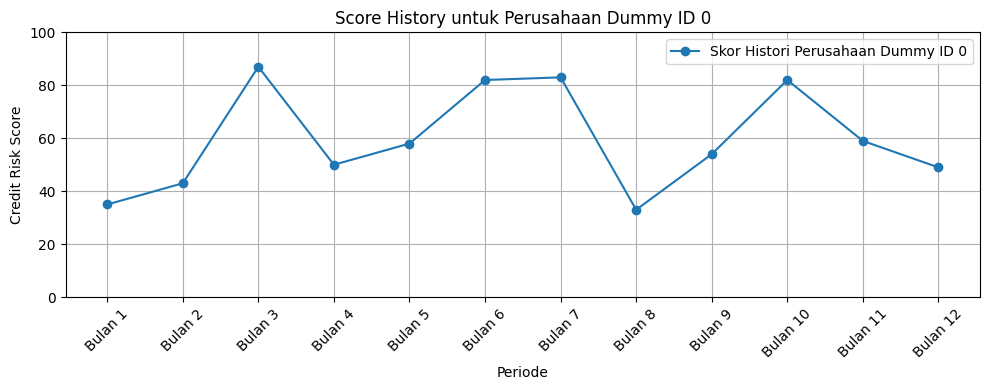

In [3]:
# 3. Score History (per applicant) - Data Dummy
applicant_ids = [company_name_sample, "Perusahaan B", "Perusahaan C"]
score_history_data = {
    company_name_sample: np.random.randint(30, 90, size=12),
    "Perusahaan B": np.random.randint(40, 100, size=12),
    "Perusahaan C": np.random.randint(20, 70, size=12)
}
months = [f"Bulan {i+1}" for i in range(12)]

plt.figure(figsize=(10, 4))
plt.plot(months, score_history_data[company_name_sample], marker='o', label=f"Skor Histori {company_name_sample}")
plt.title(f"Score History untuk {company_name_sample}")
plt.xlabel("Periode")
plt.ylabel("Credit Risk Score")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
score_history_plot = plt.gcf()
plt.show()

# 4. Approval Recommendation
recommendation = ""
recommendation_icon = ""
if risk_category == "Low Risk":
    recommendation = "Approve"
    recommendation_icon = "✔️"
elif risk_category == "Medium Risk":
    recommendation = "Butuh Review Lanjutan"
    recommendation_icon = "🟡"
else:
    recommendation = "Decline"
    recommendation_icon = "❌"
    
# Buat box untuk analisis perusahaan, agar label berada di dalam box yang rapi
analisis_box = widgets.VBox(
    [
        widgets.HTML(
            value=f"<b>Analisis untuk Perusahaan:</b> {company_name_sample}",
            layout=widgets.Layout(margin='0px 0px 5px 0px')
        )
    ],
    layout=widgets.Layout(
        border='1px solid #ccc',
        padding='10px',
        background_color='#f9f9f9',
        width='100%'
    )
)

# Tambahkan widget rekomendasi ke dalam analisis_box
rekomendasi_html = widgets.HTML(
    value=f"<b>Rekomendasi:</b> {recommendation_icon} {recommendation}",
    layout=widgets.Layout(margin='5px 0px 0px 0px')
)
analisis_box.children = list(analisis_box.children) + [
    widgets.Label("Credit Risk Score:"),
    score_gauge,
    risk_label,
    rekomendasi_html
]
display(analisis_box)


In [ ]:
import json

# Fungsi untuk menghitung M-Score berdasarkan data keuangan
def calculate_m_score(financial_data):
    # Contoh sederhana, sesuaikan dengan logika perhitungan M-Score yang sebenarnya
    # Misalnya, jika laba bersih positif dan ekuitas meningkat, skor lebih rendah (risiko rendah)
    laba_bersih = financial_data.get("Laba tahun berjalan", 0)
    ekuitas = financial_data.get("Jumlah ekuitas", 0)
    
    if laba_bersih > 0 and ekuitas > 100000000000000:
        return 'A' # Risiko sangat rendah
    elif laba_bersih > 0:
        return 'B' # Risiko rendah
    elif ekuitas < 50000000000000:
        return 'D' # Risiko sangat tinggi
    else:
        return 'C' # Risiko sedang

try:
    with open('Output/Sarana/hasil_ekstraksi_semua_dokumen.json', 'r') as f:
        sarana_output = json.load(f)
    
    # Asumsi kita menggunakan data dari dokumen pertama di JSON untuk semua perusahaan di clean_df
    # Ini adalah penyederhanaan, idealnya ada pemetaan antara perusahaan di clean_df dan data di JSON
    if sarana_output and len(sarana_output) > 0:
        financial_data_example = sarana_output[0]['hasil_ekstraksi']
        # Buat kolom M-Score baru berdasarkan perhitungan
        # Untuk demonstrasi, kita terapkan M-score yang sama ke semua baris, atau baris tertentu jika ada ID yang cocok
        # Jika Anda memiliki ID perusahaan yang cocok antara clean_df dan sarana_output, gunakan itu untuk pemetaan.
        # Untuk saat ini, kita akan membuat M-score dummy berdasarkan data pertama jika ada.
        
        # Contoh: Ambil beberapa nama perusahaan dari clean_df untuk diberi M-Score dari JSON
        # Ini hanya contoh, idealnya ada mekanisme pencocokan yang lebih baik
        target_companies = clean_df['Company name'].unique()[:len(sarana_output)] # Ambil sebanyak data di JSON
        
        m_scores_from_sarana = {}
        for i, entry in enumerate(sarana_output):
            if i < len(target_companies):
                 # Hitung M-Score dari data keuangan di JSON
                calculated_m_score = calculate_m_score(entry['hasil_ekstraksi'])
                m_scores_from_sarana[target_companies[i]] = calculated_m_score
        
        # Update MScore.2020 di clean_df (atau restricted_df jika sudah dibuat)
        # Kita akan update 'MScore.2020' dan 'MScore.2020.int'
        for index, row in restricted_df.iterrows():
            company_name = row['Company name']
            if company_name in m_scores_from_sarana:
                new_mscore = m_scores_from_sarana[company_name]
                restricted_df.loc[index, 'MScore.2020'] = new_mscore
                restricted_df.loc[index, 'MScore.2020.int'] = 0 if new_mscore.lower() in ['a', 'b'] else 1
        print("Kolom M-Score telah diperbarui menggunakan data dari Output/Sarana.")
    else:
        raise FileNotFoundError # Jika file ada tapi kosong
except FileNotFoundError:
    print("File Output/Sarana/hasil_ekstraksi_semua_dokumen.json tidak ditemukan atau kosong, membuat data M-Score dummy.")
    # Buat data M-Score dummy jika file tidak ada
    # Misalnya, kita buat distribusi acak untuk MScore.2020
    dummy_m_scores = np.random.choice(['A', 'B', 'C', 'CC', 'CCC', 'D'], size=len(restricted_df))
    restricted_df['MScore.2020'] = dummy_m_scores
    restricted_df['MScore.2020.int'] = restricted_df['MScore.2020'].apply(lambda x: 0 if str(x).lower() in ['a', 'b'] else 1)
    print("Kolom M-Score dummy telah dibuat.")

# Pastikan MScore.2019.int juga ada dan benar, karena digunakan untuk balancing
if 'MScore.2019.int' not in restricted_df.columns:
    # Jika tidak ada, buat dummy juga atau gunakan MScore.2020.int sebagai proxy
    print("Kolom MScore.2019.int tidak ditemukan, menggunakan MScore.2020.int sebagai proxy untuk balancing.")
    restricted_df['MScore.2019.int'] = restricted_df['MScore.2020.int']
    
# Re-balancing jika MScore.2019.int baru saja dibuat atau diubah
high_risk_df = restricted_df[restricted_df['MScore.2019.int'] == 1]
low_risk_df = restricted_df[restricted_df['MScore.2019.int'] == 0].sample(n=len(high_risk_df) if len(high_risk_df) > 0 else 0, random_state=0)
if len(high_risk_df) > 0 and len(low_risk_df) > 0:
    restricted_df = pd.concat([low_risk_df, high_risk_df])
    restricted_df.sort_index(inplace=True)
else:
    print("Tidak cukup data untuk balancing setelah update M-Score.")
    # Jika tidak ada cukup data, mungkin kita gunakan seluruh clean_df tanpa balancing MScore.2019.int
    # Atau handle error sesuai kebutuhan
    # Untuk sekarang, kita lanjutkan dengan restricted_df yang mungkin tidak seimbang pada MScore.2019.int
    # Ini bisa mempengaruhi pelatihan model, jadi idealnya ada data yang cukup

restricted_df.head() # Tampilkan hasil untuk verifikasi

# Pastikan kolom yang akan digunakan untuk prediksi (misal MScore.2019.int) ada di restricted_df
# dan variabel target (MScore.2020.int) juga ada.
print("\nDistribusi MScore.2019.int setelah update/dummy:")
print(restricted_df['MScore.2019.int'].value_counts())
print("\nDistribusi MScore.2020.int setelah update/dummy:")
print(restricted_df['MScore.2020.int'].value_counts())

Kolom M-Score telah diperbarui menggunakan data dari Output/Sarana.

Distribusi MScore.2019.int setelah update/dummy:
MScore.2019.int
1    2446
0    2446
Name: count, dtype: int64

Distribusi MScore.2020.int setelah update/dummy:
MScore.2020.int
0    3157
1    1735
Name: count, dtype: int64
